## Unsupervised Learning in Python

### CHAPTER 1. Clustering for data analysis

#### 1.1 Unsupervised learning

* Unsupervised learning finds patterns in data
* Examples: clustering, dimension reduction

* Supervised VS. unsupervised learning
    * Supervised learning finds pattern for a prediction task with labeled data
    * Unsupervised learning finds pattern in data (purely discovery) without labels
    
* k-means clustering:
    * Finds clusters of samples
    * Number of clusters must be specified
    * New samples can be assigned to existing clusters
    * k-means remembers the mean of each cluster (centroids) and finds the nearest centroid to each new sample 

In [1]:
# k-means in scikit-learn
from sklearn.cluster import KMeans
from sklearn import datasets
import pandas as pd

# get iris data
iris = datasets.load_iris()
samples = iris.data

# create k-means model
model = KMeans(n_clusters=3)
model.fit(samples)
labels = model.predict(samples)
print(labels)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2 0 2 2 2 2
 2 2 0 0 2 2 2 2 0 2 0 2 0 2 2 0 0 2 2 2 2 2 0 2 2 2 2 0 2 2 2 0 2 2 2 0 2
 2 0]


In [2]:
# cluster labels for new samples
new_samples = [[5.0, 3.3, 1.4, 0.2],
              [5.0, 3.5, 1.3, 0.3],
              [7.2, 3.2, 6.0, 1.8]]
new_labels = model.predict(new_samples)
print(new_labels)

[1 1 2]


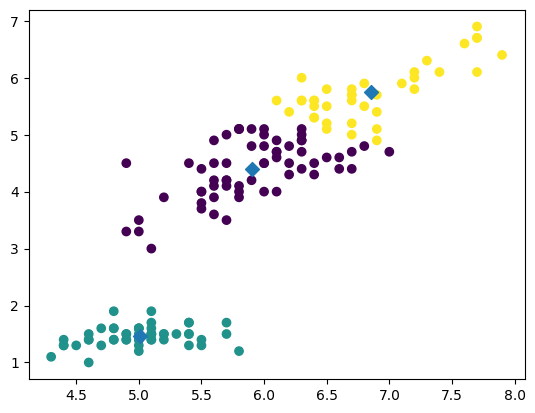

In [3]:
# visualize clusters by scatter plots
import matplotlib.pyplot as plt
xs = samples[:, 0]
ys = samples[:, 2]
plt.scatter(xs, ys, c=labels)

centroids = model.cluster_centers_
centroids_x = centroids[:, 0]
centroids_y = centroids[:, 2]
plt.scatter(centroids_x, centroids_y, marker='D', s=50)

plt.show()

#### 1.2 Evaluating a clustering

* Can check correpondence with labels (e.g: iris species)
    * Clusters VS. species is a "cross-tabulation"
* Measure quality of clustering
    * A good clustering has tight clusters
    * Samples in each cluster bunched together
    * **Inertia** measures how spread out the clusters are (*lower* is better)
* Informs choice of how many clusters to look for 
    * A good clustering has tight clusters (so low inertia)
    * ... but not too many clusters!
    * Need to make a trade-off!
    * Choose an **"elbow"** in the inertia plot


In [4]:
# cross tabulation with pandas
import pandas as pd
species = iris.target
df = pd.DataFrame({'labels': labels, 'species': species})
ct = pd.crosstab(df['labels'], df['species'])
print(ct)

species   0   1   2
labels             
0         0  48  14
1        50   0   0
2         0   2  36


In [5]:
# inertia in scikit-learn
from sklearn.cluster import KMeans
model = KMeans(n_clusters=3)
model.fit(samples)
print(model.inertia_)

78.85144142614601


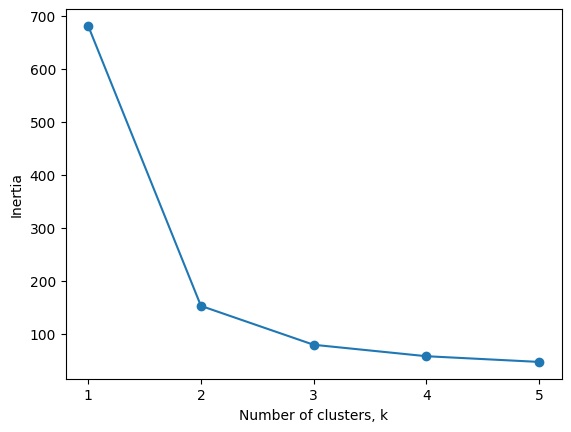

In [6]:
# inertia plot in python
import matplotlib.pyplot as plt
ks = range(1, 6)
inertias = []
for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(samples)
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()
# it looks like 3 is a good choice

#### 1.3 Transforming features for better clustering

* In kmeans, feature variance = feature influence
* Data needs to be transformed so features have equal variance
* **StandardScaler** can transform each feature to have mean 0 and variance 1
* In this way, feature are **"standardized"**
* Other similar methods include: **MaxAbsScaler** and **Normalizer**

In [7]:
# clustering the wines
import pandas as pd
from sklearn.cluster import KMeans
wine_df = pd.read_csv('2_datasets/wine.csv')
samples = wine_df.drop(['class_label', 'class_name'], axis=1).values
model = KMeans(n_clusters=3)
labels = model.fit_predict(samples)

In [8]:
# clusters VS. varieries
varieties = wine_df['class_name'].values
df = pd.DataFrame({'labels': labels, 'varieties': varieties})
ct = pd.crosstab(df['labels'], df['varieties'])
print(ct)
# things don't work out so well this time

varieties  Barbera  Barolo  Grignolino
labels                                
0               19       0          50
1                0      46           1
2               29      13          20


In [9]:
# StandardScaler in scikit-learn
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(samples)
StandardScaler(copy=True, with_mean=True, with_std=True)
samples_scaled = scaler.transform(samples)

In [10]:
# two steps pipeline for StandardScaler and KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
scaler = StandardScaler()
kmeans = KMeans(n_clusters=3)
pipeline = make_pipeline(scaler, kmeans)
pipeline.fit(samples)
labels = pipeline.predict(samples)

# check new crosstab after standardization
df = pd.DataFrame({'labels': labels, 'varieties': varieties})
ct = pd.crosstab(df['labels'], df['varieties'])
print(ct)
# the result is much better this time

varieties  Barbera  Barolo  Grignolino
labels                                
0               48       0           3
1                0      59           3
2                0       0          65


### CHAPTER 2. Visualization with hierarchical clustering and t-SNE

#### 2.1 Visualizing hierarchies

* Groups of living things can form a hierarchy
* Clusters are contained in one another

Hierarchical clustering steps:
* Every row is a separate cluster
* At each step, the two closest clusters are merged
* Continue until all rows are in a single cluster
* The process will create a plot called **dendrogram**

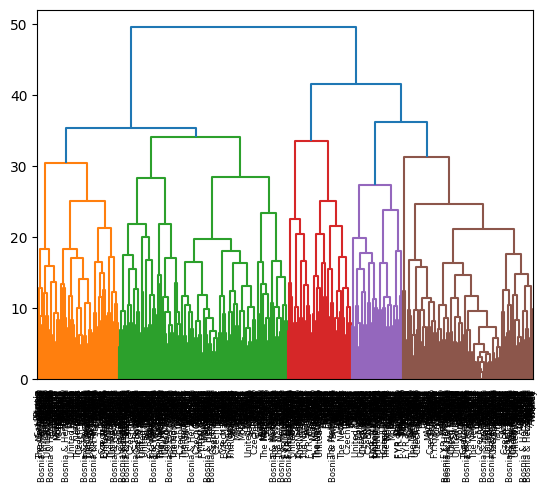

In [11]:
# eurovision hierarchy clustering in SciPy
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

# get arrays
eurovision_df = pd.read_csv('2_datasets/eurovision_2016.csv')
samples = eurovision_df.iloc[:, 2:6].values
country_names = eurovision_df['From country'].values

# hierarchy and plot
mergings = linkage(samples, method='complete')
dendrogram(mergings, labels=country_names, leaf_rotation=90, leaf_font_size=6)
plt.show()

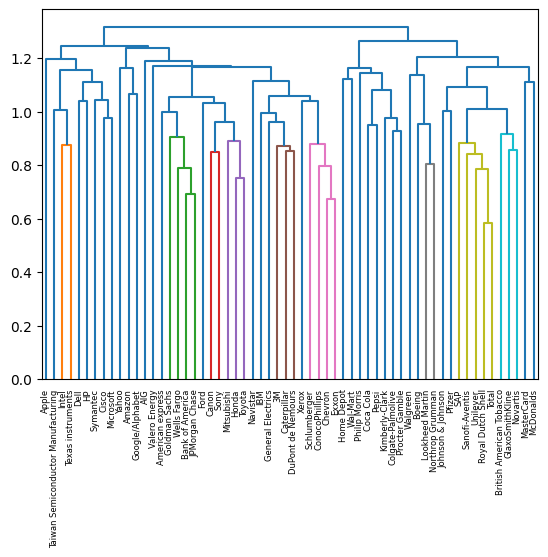

In [12]:
# stock movement hierarchy clustering in SciPy
from sklearn.preprocessing import normalize

# get arrays
stock_df = pd.read_csv('2_datasets/stock_price.csv')
stock_df = stock_df.rename(columns={'Unnamed: 0': 'companies'})
movements = stock_df.drop('companies', axis=1).values
companies = stock_df['companies'].values

# hierarchy and plot
normalized_movements = normalize(movements)
mergings = linkage(normalized_movements, method='complete')
dendrogram(mergings, labels=companies, leaf_rotation=90, leaf_font_size=6)
plt.show()

#### 2.2 Cluster labels in hierarchical clustering

* Hierarchical clustering is **NOT ONLY a visualization tool**
* Cluster labels at any intermediate stage can be recovered
* **Intermediate stage** is specified by choosing a height on the dendrogram
* Distance between clusters is defined by a **"linkage method"**
* Different linkage method, different hierarchical clustering
* Extracting cluster labels by *fcluster()* function
*

In [13]:
# extracting stock movement cluster labels using fcluster
from scipy.cluster.hierarchy import linkage, fcluster
mergings = linkage(normalized_movements, method='complete')
labels = fcluster(mergings, 1.0, criterion='distance')
print(labels)

[ 7 19  8 11 25 11 30 12 14 23 15  5 15 14  3 13 14  9 11 30 20 12  4 14
  1 27 11 23 22 25 31 32 14  5 12 17 25 30 22 28 23 24 29 29 15 12 29  6
 12 29  2  1 29 18 26 11 21 15 16 10]


In [14]:
# align cluster labels with actual labels
import pandas as pd
pairs = pd.DataFrame({'labels': labels, 'companies': companies})
print(pairs.sort_values('labels'))

    labels                           companies
51       1                   Texas instruments
24       1                               Intel
50       2  Taiwan Semiconductor Manufacturing
14       3                                Dell
22       4                                  HP
33       5                           Microsoft
11       5                               Cisco
47       6                            Symantec
0        7                               Apple
2        8                              Amazon
17       9                     Google/Alphabet
59      10                               Yahoo
26      11                      JPMorgan Chase
18      11                       Goldman Sachs
55      11                         Wells Fargo
3       11                    American express
5       11                     Bank of America
7       12                               Canon
34      12                          Mitsubishi
45      12                                Sony
48      12   

#### 2.3 t-SNE for 2-dimensional maps

* t-SNE = "t-distributed stochastic neighbor embedding"
* It maps samples to 2D space (or 3D)
* Map approximately preserves nearness of samples
* Great for inspecting datasets

* TSNE features:
    1) TSNE only has a *fit_transform()* method to simultaneously fits the model and transforms the data, it CANNOT transform new samples
    2) Choose different learning rates for different datasets, try values between 50 and 200
    3) The axes of TSNE plot **DO NOT** have any interpretable meaning, the features are different every time!

E:\PYTHON\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


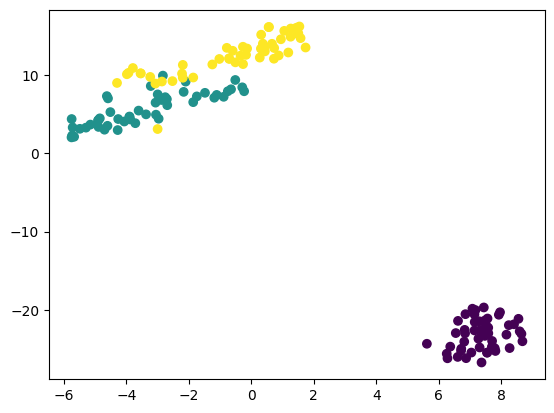

In [15]:
# t-SNE of iris in scikit-learn
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

iris = datasets.load_iris()
samples = iris.data
species = iris.target

# create TSNE and plot
model = TSNE(learning_rate=100)
transformed = model.fit_transform(samples)
xs = transformed[:, 0]
ys = transformed[:, 1]
plt.scatter(xs, ys, c=species)
plt.show()

E:\PYTHON\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


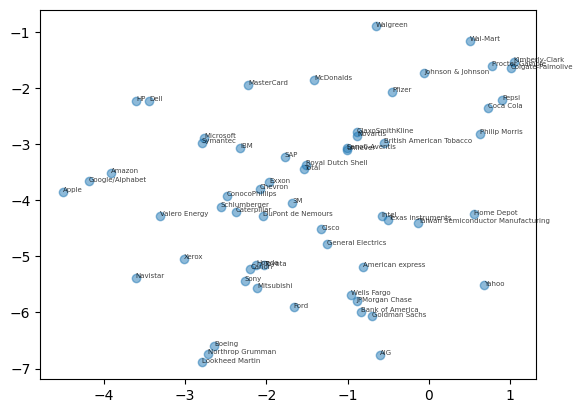

In [16]:
# t-SNE map of stock movement in scikit-learn
from sklearn.manifold import TSNE
model = TSNE(learning_rate=50)
tsne_features = model.fit_transform(normalized_movements)
xs = tsne_features[:, 0]
ys = tsne_features[:, 1]
plt.scatter(xs, ys, alpha=0.5)

# annotate the points
for x, y, company in zip(xs, ys, companies):
    plt.annotate(company, (x, y), fontsize=5, alpha=0.75)
plt.show()

### CHAPTER 3. De-correlating your data and dimension reduction

#### 3.1 Visualizing the PCA transformation

* Dimension reduction finds patterns in data and use patterns to re-express it in compressed form
* More efficient storage and computation
* Remove less-informative "noise" features

**Principal Component Analysis (PCA)** is the most fundamental dimension reduction technique:

   * Step 1: decorrelation
        * Rotates data samples to be aligned with axes
        * Shifts data samples so they have mean 0
        * No information is lost
        * Rows of transformed correspond to samples
        * Columns of transfromed are the **"PCA features"** which are **NOT correlated**
        * Correlation can be measured by **Pearson correlation**, its value is between -1 and 1
   * Step 2: reduces dimension
        * "Principal components" = directions of variance

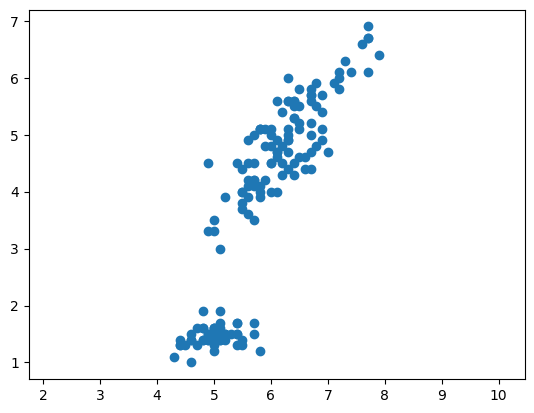

0.8717537758865833


In [17]:
# correlation in data
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn import datasets

iris = datasets.load_iris()
samples = iris.data
width = samples[:, 0]
length = samples[:, 2]

# scatter plot
plt.scatter(width, length)
plt.axis('equal')
plt.show()

# calculate correlation
correlation, pvalue = pearsonr(width, length)
print(correlation)

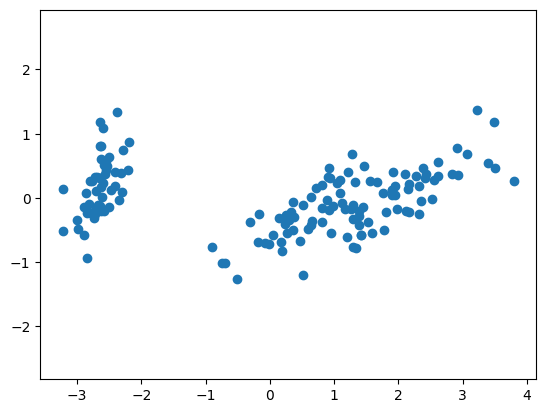

9.8879238130678e-17


In [18]:
# PCA in scikit-learn
from sklearn.decomposition import PCA

# get PCA features
model = PCA()
pca_features = model.fit_transform(samples)
xs = pca_features[:, 0]
ys = pca_features[:, 1]

# scatter plot
plt.scatter(xs, ys)
plt.axis('equal')
plt.show()

# calculate correlation
correlation, pvalue = pearsonr(xs, ys)
print(correlation)
# the PCA features are NOT correlated

#### 3.2 Intrinsic dimension

* Intrinsic dimension = number of features needed to approximate the dataset
* It is the essential idea behind dimension reduction
* It can be detected with PCA
* Intrinsic dimension = number of PCA features with significant variance
* However, there is not always one correct answer!

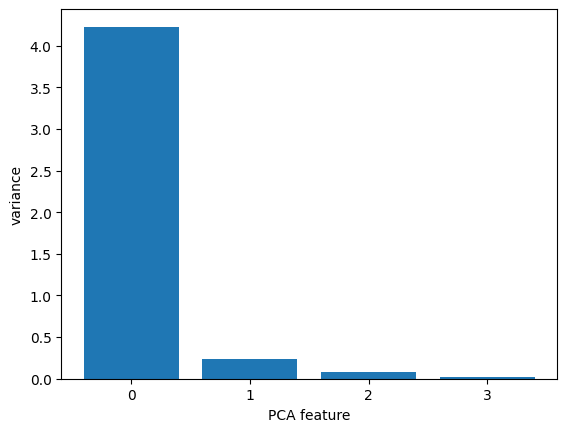

In [19]:
# plotting variance of PCA features
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(samples)
features = range(pca.n_components_)

# bar plot
plt.bar(features, pca.explained_variance_)
plt.xticks(features)
plt.ylabel('variance')
plt.xlabel('PCA feature')
plt.show()
# only first 2 PCA features are significant that can be intrinsic dimension

#### 3.3 Dimension reduction with PCA

* Dimension reductin represents the same data with less features
* It is an important part of machine-learning pipelines
* It can be performed with PCA
* Specify how many features to keep
* Similar methods can be applied to word frequency count dimension reduction


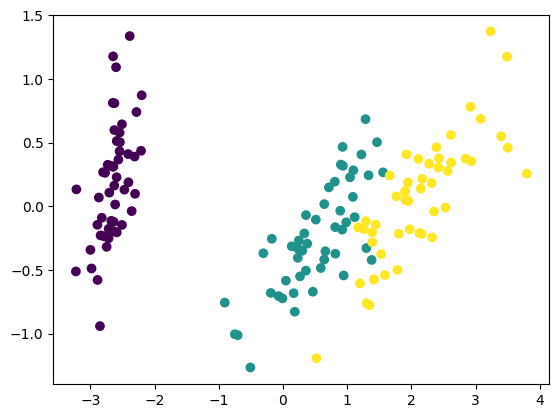

In [20]:
# dimension reduction in scikit-learn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCA has reduced the dimension to 2
pca = PCA(n_components=2)
pca.fit(samples)
transformed = pca.transform(samples)

# plot dataset in 2 dimensions
xs = transformed[:, 0]
ys = transformed[:, 1]
plt.scatter(xs, ys, c=species)
plt.show()

In [21]:
# dimension reduction for Wikipedia articles
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

# extract from dataframe
wikipedia_df = pd.read_csv('2_datasets/wikipedia-vectors.csv')
wikipedia_df = wikipedia_df.rename(columns={'Unnamed: 0': 'Count'})
articles = wikipedia_df.drop('Count', axis=1).values
articles = csr_matrix(articles).transpose()
titles = wikipedia_df.drop('Count',axis=1).columns.tolist()

# create pipeline
svd = TruncatedSVD(n_components=50)
kmeans = KMeans(n_clusters=6)
pipeline = make_pipeline(svd, kmeans)

# apply pipeline for dimension reduction
pipeline.fit(articles)
labels = pipeline.predict(articles)
df = pd.DataFrame({'label': labels, 'article': titles})
print(df.sort_values('label'))

    label                                        article
41      0                                    Hepatitis B
42      0                                    Doxycycline
43      0                                       Leukemia
44      0                                           Gout
45      0                                    Hepatitis C
46      0                                     Prednisone
47      0                                          Fever
48      0                                     Gabapentin
49      0                                       Lymphoma
40      0                                    Tonsillitis
59      1                                    Adam Levine
58      1                                         Sepsis
50      1                                   Chad Kroeger
57      1                          Red Hot Chili Peppers
56      1                                       Skrillex
55      1                                  Black Sabbath
54      1                      

### CHAPTER 4. Discovering interpretable features

#### 4.1 Non-negative matrix factorization (NMF)

* NMF = "non-negative matrix factorization"
* NMF is also a **dimension reduction** technique
* NMF models are **interpretable** (unlike PCA)
* It requires all sample features must be **non-negative** (>=0)

NMF Features:
1. Follow *fit()/transform()* pattern
2. Must specify number of components
3. Works with *NumPy arrays* and with *csr_matrix*
4. It has components (just like PCA), dimension of components = dimension of samples
5. Its feature values are *non-negative*
6. **Combine** feature values and components with **product of matrices**, we can **reconstruct** the samples

In [22]:
# NMF in scikit-learn
from sklearn.decomposition import NMF
import pandas as pd

# extract from dataframe
wikipedia_df = pd.read_csv('2_datasets/wikipedia-vectors.csv')
wikipedia_df = wikipedia_df.rename(columns={'Unnamed: 0': 'Count'})
samples = wikipedia_df.drop('Count', axis=1).values

# create NMF model
model = NMF(n_components=2)
model.fit(samples)
nmf_features = model.transform(samples)

print(nmf_features)
print(model.components_)
print('Samples shape: {}'.format(samples.shape))
print('NMF features shape: {}'.format(nmf_features.shape))
print('NMF components shape: {}'.format(model.components_.shape))

[[0.00919268 0.        ]
 [0.00079853 0.        ]
 [0.00283059 0.00781021]
 ...
 [0.00108715 0.00348429]
 [0.00448937 0.00113915]
 [0.         0.        ]]
[[0.0404108  0.07403882 0.05802497 0.03864041 0.04325369 0.08194668
  0.0336934  0.04714292 0.10293745 0.10238649 0.         0.
  0.05447401 0.01012248 0.01282792 0.         0.02687391 0.
  0.         0.         0.31159534 0.2947079  0.23164611 0.24494514
  0.28124768 0.32633812 0.33735704 0.28802271 0.34259999 0.31472869
  0.         0.         0.00769824 0.         0.         0.
  0.         0.02680214 0.00836174 0.         0.06398601 0.06610605
  0.06089893 0.0936312  0.07333459 0.07089362 0.05875938 0.03635642
  0.0800188  0.06567579 0.32103085 0.38726253 0.44127303 0.42374609
  0.45023449 0.47457978 0.32916697 0.46480589 0.35506345 0.46687565]
 [0.03100491 0.04118949 0.02977098 0.02907254 0.02661813 0.0429583
  0.03859248 0.02504672 0.05485014 0.06967031 0.18726045 0.12264714
  0.12360012 0.12826549 0.1575852  0.16918121 0.1532

In [23]:
# reconstruction of a sample
import numpy as np
reconstructed_samples = np.dot(nmf_features, model.components_)

#### 4.2 NMF learns interpretable parts

* Components of NMF represent patterns that frequently occur in the samples
* For documents:
    * NMF components represent topics
    * NMF features combine topics into documents
* For images, NMF components are parts of image
    * "Grayscale" image = no colors, only shades of gray
    * Measure pixel brightness with value between 0 and 1 (0 is black)
    * Images can be converted to 2D array

In [24]:
# NMF learns topics of documents
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.decomposition import NMF

# get articles/documents
wikipedia_df = pd.read_csv('2_datasets/wikipedia-vectors.csv')
wikipedia_df = wikipedia_df.rename(columns={'Unnamed: 0': 'Count'})
articles = wikipedia_df.drop('Count', axis=1).values
articles = csr_matrix(articles).transpose()
words = pd.read_csv('2_datasets/wikipedia-vocabulary-utf8.txt', header=None)
words = words.iloc[:, 0].tolist()
print(len(words)) # 13125 words
print(articles.shape) # 13125 articles, 60 titles

# create a model
model = NMF(n_components=6)
model.fit(articles)
print(model.components_.shape)

# create a dataframe
components_df = pd.DataFrame(model.components_, columns=words)
print(components_df.shape)
print(components_df.head(5))

# check one of the rows
component = components_df.iloc[3]
print(component.nlargest()) # find words that related to the article

13125
(60, 13125)
(6, 13125)
(6, 13125)
      aaron   abandon  abandoned  abandoning  abandonment  abbas  abbey  \
0  0.011509  0.001224   0.000000    0.001759     0.000138    0.0    0.0   
1  0.000000  0.000010   0.005695    0.000000     0.000002    0.0    0.0   
2  0.000000  0.000008   0.000000    0.000000     0.004715    0.0    0.0   
3  0.004176  0.000000   0.003077    0.000000     0.000618    0.0    0.0   
4  0.000000  0.000571   0.004941    0.000000     0.000000    0.0    0.0   

   abbreviated  abbreviation       abc  ...   zealand  zenith  zeppelin  \
0     0.002493  3.004137e-07  0.000844  ...  0.026084     0.0  0.008421   
1     0.000569  5.030654e-04  0.000000  ...  0.008152     0.0  0.000000   
2     0.000762  1.613336e-05  0.000000  ...  0.008774     0.0  0.000000   
3     0.002452  8.193499e-05  0.004012  ...  0.012678     0.0  0.000000   
4     0.000089  4.279030e-05  0.000000  ...  0.001818     0.0  0.000000   

       zero  zeus  zimbabwe  zinc      zone     zones  zoo

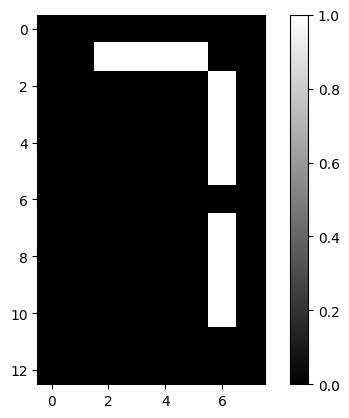

In [25]:
# explore the LED digits datasets
import matplotlib.pyplot as plt
import pandas as pd

LED_digits = pd.read_csv('2_datasets/LCD_digits.csv', header=None)
samples = LED_digits.values

# print one of the digits
digit = samples[0,:]
bitmap = digit.reshape([13, 8])
plt.imshow(bitmap, cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()

In [26]:
# create a function to show image
def show_as_image(sample):
    bitmap = sample.reshape([13, 8])
    plt.figure()
    plt.imshow(bitmap, cmap='gray', interpolation='nearest')
    plt.colorbar()
    plt.show()

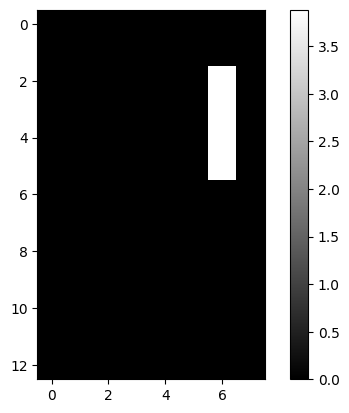

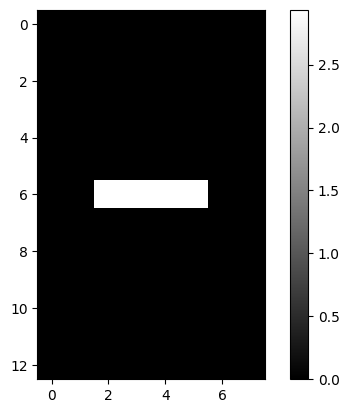

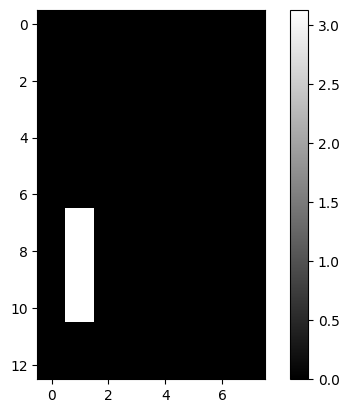

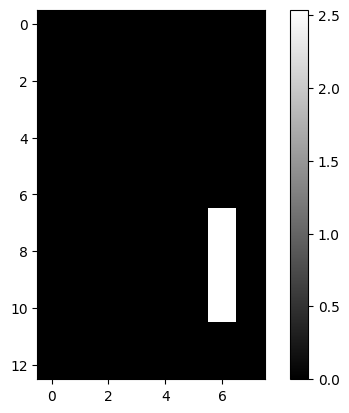

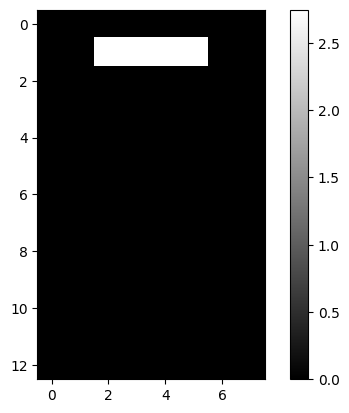

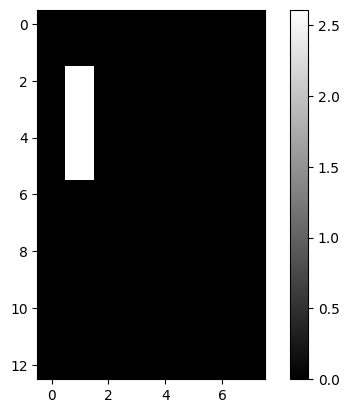

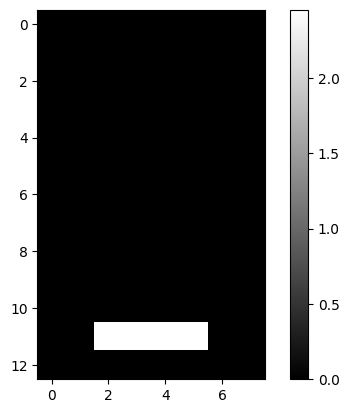

[2.57347960e-01 0.00000000e+00 0.00000000e+00 3.94333376e-01
 3.64045642e-01 0.00000000e+00 3.51282024e-14]


In [27]:
# NMF learns parts of images
from sklearn.decomposition import NMF

# create a NMF model
model = NMF(n_components=7)
features = model.fit_transform(samples)
for component in model.components_:
    show_as_image(component)

# assign the 0th row of features
digit_features = features[0,:]
print(digit_features)
# NMF expresses the digit as a sum of the components

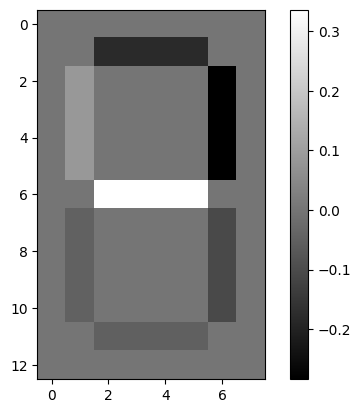

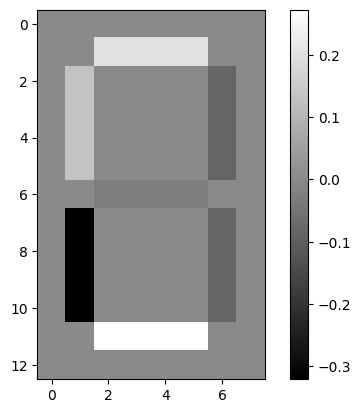

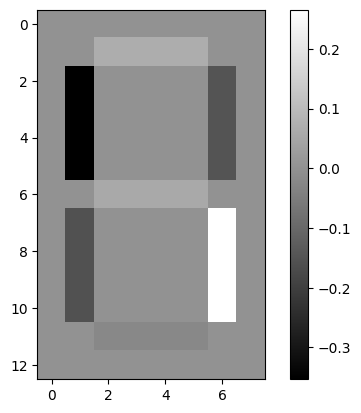

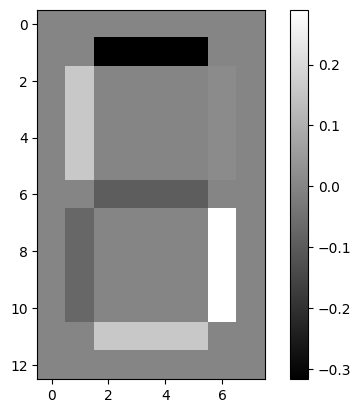

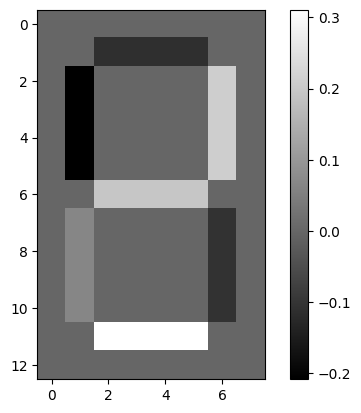

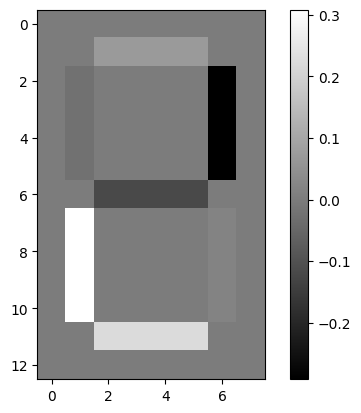

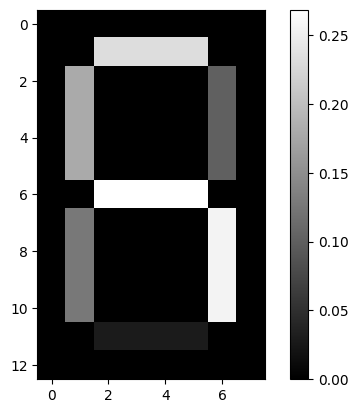

In [28]:
# PCA does not learn parts
from sklearn.decomposition import PCA

# create a PCA model
model = PCA(n_components=7)
features = model.fit_transform(samples)
for component in model.components_:
    show_as_image(component)

# PCA components do not represent meaningful parts of images of LED digits!

#### 4.3 Building recommender systems using NMF

**Recommender Strategy**:
* Apply NMF to the word-frequency array
* NMF feature values describe the topics
* Similar documents have similar NMF feature values
* We use cosine similarity (angle between the lines represent documents)
    1. Higher values means more similar
    2. Maximum value is 1

In [29]:
# apply NMF to word-frequency array in scikit-learn
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.decomposition import NMF

# get articles/documents
wikipedia_df = pd.read_csv('2_datasets/wikipedia-vectors.csv')
wikipedia_df = wikipedia_df.rename(columns={'Unnamed: 0': 'Count'})
articles = wikipedia_df.drop('Count', axis=1).values
articles = csr_matrix(articles).transpose()
titles = wikipedia_df.drop('Count', axis=1).columns
print(len(titles))
print(articles.shape)

60
(60, 13125)


In [30]:
# create a NMF model
nmf = NMF(n_components=6)
nmf_features = nmf.fit_transform(articles)

In [31]:
# calculate the cosine similarities: example
from sklearn.preprocessing import normalize
norm_features = normalize(nmf_features)

current_article = norm_features[23, :]
similarities = norm_features.dot(current_article)
print(similarities)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 9.89802611e-02 0.00000000e+00 0.00000000e+00
 4.90120502e-02 1.88165433e-01 0.00000000e+00 0.00000000e+00
 1.90667824e-01 3.22597866e-02 0.00000000e+00 0.00000000e+00
 8.58022997e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.92341550e-01 1.00000000e+00 9.99911454e-01 1.00000000e+00
 1.00000000e+00 9.45689065e-01 9.99921431e-01 9.99047851e-01
 9.99977281e-01 9.99323470e-01 0.00000000e+00 1.02522590e-02
 7.01540690e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.07947043e-01 5.18926401e-02 3.64569379e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.03947170e-02
 1.08225251e-03 0.00000000e+00 0.00000000e+00 9.99141070e-04
 3.11425514e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.26470174e-02 9.89393644e-02 0.00000000e+00 0.00000000e+00
 1.89037705e-01 0.00000000e+00 3.02498540e-02 2.52739006e-01]


In [32]:
# which articles are similar to 'Cristiano Ronaldo'?
import pandas as pd
norm_features = normalize(nmf_features)
df = pd.DataFrame(norm_features, index=titles)
current_article = df.loc['Cristiano Ronaldo']
similarities = df.dot(current_article)
print(similarities.nlargest())

Cristiano Ronaldo                1.000000
Franck Ribéry                    0.999973
Radamel Falcao                   0.999942
Zlatan Ibrahimović               0.999942
France national football team    0.999923
dtype: float64


In [33]:
# recommended musical artist
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.decomposition import NMF
from sklearn.preprocessing import Normalizer, MaxAbsScaler
from sklearn.pipeline import make_pipeline

# get sparse array for musical artist
scrobbler_df = pd.read_csv('2_datasets/scrobbler-small-sample.csv')
print(scrobbler_df.columns)

row = scrobbler_df["artist_offset"].values
col = scrobbler_df["user_offset"].values
data = scrobbler_df["playcount"].values

artists = csr_matrix((data, (row, col)), shape=(111, 500)).toarray()
print(artists.shape)

Index(['user_offset', 'artist_offset', 'playcount'], dtype='object')
(111, 500)


In [34]:
# create a NMF model pipeline
scaler = MaxAbsScaler()
nmf = NMF(n_components=20)
normalizer = Normalizer()
pipeline = make_pipeline(scaler, nmf, normalizer)
norm_features = pipeline.fit_transform(artists)
print('NMF features shape: {}'.format(norm_features.shape))

# calculate similarities
artist_names = pd.read_csv('2_datasets/artists.csv', header=None)
artist_names = artist_names.iloc[:, 0].tolist()
print(artist_names)

df = pd.DataFrame(norm_features, index=artist_names)
artist = df.loc['Bruce Springsteen']
similarities = df.dot(artist)
print(similarities.nlargest())

NMF features shape: (111, 20)
['Massive Attack', 'Sublime', 'Beastie Boys', 'Neil Young', 'Dead Kennedys', 'Orbital', 'Miles Davis', 'Leonard Cohen', 'Van Morrison', 'NOFX', 'Rancid', 'Lamb', 'Korn', 'Dropkick Murphys', 'Bob Dylan', 'Eminem', 'Nirvana', 'Van Halen', 'Damien Rice', 'Elvis Costello', 'Everclear', 'Jimi Hendrix', 'PJ Harvey', 'Red Hot Chili Peppers', 'Ryan Adams', 'Soundgarden', 'The White Stripes', 'Madonna', 'Eric Clapton', 'Bob Marley', 'Dr. Dre', 'The Flaming Lips', 'Tom Waits', 'Moby', 'Cypress Hill', 'Garbage', 'Fear Factory', '50 Cent', 'Ani DiFranco', 'Matchbox Twenty', 'The Police', 'Eagles', 'Phish', 'Stone Temple Pilots', 'Black Sabbath', 'Britney Spears', 'Fatboy Slim', 'System of a Down', 'Simon & Garfunkel', 'Snoop Dogg', 'Aimee Mann', 'Less Than Jake', 'Rammstein', 'Reel Big Fish', 'The Prodigy', 'Pantera', 'Foo Fighters', 'The Beatles', 'Incubus', 'Audioslave', 'Bright Eyes', 'Machine Head', 'AC/DC', 'Dire Straits', 'Motörhead', 'Ramones', 'Slipknot', 'Me 

Welcome to the end of this course!